In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [43]:
import pathlib
import os

dataset_url = "https://github.com/PedroAugustoRamalhoDuarte/fsi/blob/main/projeto2/data/TomatoPestImageEnhancement.zip?raw=true"

data_dir = tf.keras.utils.get_file('flowers', origin=dataset_url, extract=True)

data_dir = pathlib.Path(data_dir)

63332352/63321217 [==============================] - 0s 0us/step


In [44]:
import os
base = os.path.dirname(data_dir)
!find $base -type d -print

/root/.keras/datasets
/root/.keras/datasets/Tomato pest image enhancement
/root/.keras/datasets/Tomato pest image enhancement/HA
/root/.keras/datasets/Tomato pest image enhancement/MP
/root/.keras/datasets/Tomato pest image enhancement/BA
/root/.keras/datasets/Tomato pest image enhancement/TP
/root/.keras/datasets/Tomato pest image enhancement/SL
/root/.keras/datasets/Tomato pest image enhancement/SE
/root/.keras/datasets/Tomato pest image enhancement/TU
/root/.keras/datasets/Tomato pest image enhancement/ZC


In [29]:
# Variables
DATASET_DIR = '/root/.keras/datasets/Tomato pest image enhancement'
CLASSES_SIZE = 8
img_height,img_width=299,299
batch_size=32

# Get train and val dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4263 files belonging to 8 classes.
Using 3411 files for training.
Found 4263 files belonging to 8 classes.
Using 852 files for validation.


In [33]:
CLASSES_NAMES = train_ds.class_names

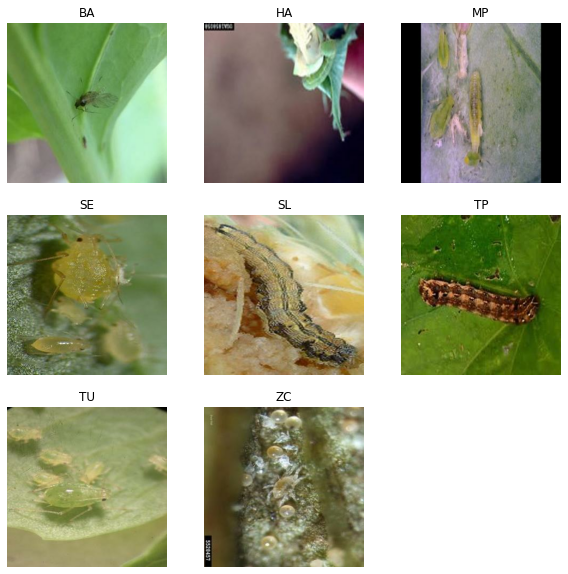

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(CLASSES_SIZE):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASSES_NAMES[i])
        plt.axis("off")

In [7]:
resnet_model = keras.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                                                 input_shape=(img_height,img_width,3),
                                                 pooling='avg',classes=CLASSES_SIZE,
                                                 weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(CLASSES_SIZE, activation='softmax'))

resnet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 1,053,192
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
107/107 [==============================] - 63s 523ms/step - loss: 0.6795 - accuracy: 0.7728 - val_loss: 0.2935 - val_accuracy: 0.8908
Epoch 2/10
107/107 [==============================] - 52s 482ms/step - loss: 0.1677 - accuracy: 0.9484 - val_loss: 0.1591 - val_accuracy: 0.9566
Epoch 3/10
107/107 [==============================] - 52s 483ms/step - loss: 0.0717 - accuracy: 0.9833 - val_loss: 0.1526 - val_accuracy: 0.9577
Epoch 4/10
107/107 [==============================] - 52s 482ms/step - loss: 0.0368 - accuracy: 0.9938 - val_loss: 0.1354 - val_accuracy: 0.9589
Epoch 5/10
107/107 [==============================] - 52s 483ms/step - loss: 0.0183 - accuracy: 0.9971 - val_loss: 0.1187 - val_accuracy: 0.9554
Epoch 6/10
107/107 [==============================] - 52s 482ms/step - loss: 0.0176 - accuracy: 0.9965 - val_loss: 0.1064 - val_accuracy: 0.9660
Epoch 7/10
107/107 [==============================] - 52s 481ms/step - loss: 0.0176 - accuracy: 0.9962 - val_loss: 0.1128 - val_ac

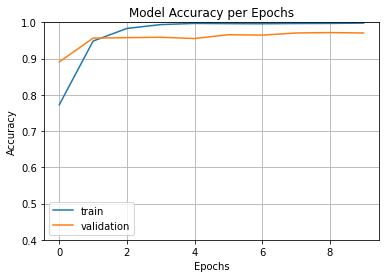

In [40]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy per Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [23]:
y_true = []
y_pred = []
validation_images = []
for imgs, labels in val_ds:
    for label in labels:
        y_true.append(label)
    for img in imgs:
        validation_images.append(img)
        y_pred.append(resnet_model.predict(np.expand_dims(img, axis=0)))
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [38]:
# Get metrics
from sklearn.metrics import classification_report, f1_score
y_pred_after = np.argmax(y_pred, axis=2).flatten()
report = classification_report(y_true, y_pred_after, target_names=CLASSES_NAMES)
print(type(report))
print(report)


<class 'str'>
              precision    recall  f1-score   support

          BA       0.97      0.99      0.98        77
          HA       0.94      0.97      0.95       150
          MP       0.99      0.98      0.98       181
          SE       0.94      0.92      0.93       105
          SL       0.98      0.95      0.96       130
          TP       1.00      0.97      0.98        33
          TU       0.98      1.00      0.99       118
          ZC       1.00      1.00      1.00        58

    accuracy                           0.97       852
   macro avg       0.97      0.97      0.97       852
weighted avg       0.97      0.97      0.97       852



In [31]:
# Accuracy
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true, y_pred_after)
matrix.diagonal()/matrix.sum(axis=1)

array([0.98701299, 0.96666667, 0.97790055, 0.92380952, 0.95384615,
       0.96969697, 1.        , 1.        ])

In [39]:
# Referências
# Projeto baseado em https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/
# https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
# 2 - O resultado do projeto foi bom, conseguindo um accurácia extremanente elevada para os desafios do projeto em
# questão. Em termos de melhoria, creio que esse resultado já é bem satisfatório, porém sempre é possível testar se
# melhora os resultados utilizando um dataset maior de imagens, caso não seja possível encontrar um dataset maior, podemos
# utilizar algumas técnicas como rotacionar em outras angulações as imagens para gerar mais imagens para os nossos testes,
# outra ideia interessante é aumentar o número de epochs no argumento da função model fit